## Homework 03

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds


### 1. Dataset

In [2]:
# Load Bacteria Dataset from tfds
ds_train, ds_test = tfds.load("genomics_ood", split=['train[:100000]', 'test[:1000]'], shuffle_files=True, as_supervised=True)

In [3]:
def one_hot_sequence(seq: tf.Tensor) -> tf.Tensor:
    """Convert sequence of characters (A,C,G,T) to one-hot representation.
    :param seq: sequence to translate to one-hot
    :type seq: tf.Tensor
    :return: one-hot tensor that is 4 times longer than the non-one-hot tensor
    :rtype: tf.Tensor
    """
    seq = tf.strings.regex_replace(seq, 'A', '0')
    seq = tf.strings.regex_replace(seq, 'C', '1')
    seq = tf.strings.regex_replace(seq, 'G', '2')
    seq = tf.strings.regex_replace(seq, 'T', '3')
    split_seq = tf.strings.bytes_split(seq)
    int_seq = tf.cast(tf.strings.to_number(split_seq), dtype=tf.int32)
    onehot = tf.one_hot(int_seq, 4)
    onehot = tf.reshape(onehot, (-1,))
    return onehot

In [4]:
def preprocessing_pipeline(data):
    """Apply preproccesing pipeline to the given dataset.
    
    :param data: data to be preprocessed
    :type data: tensorflow 'Dataset'
    :return: preprocessed dataset
    :rtype: tensorflow 'Dataset'
    """
    # one hot the sequences and their labels
    data = data.map(lambda seq, label: (
        one_hot_sequence(seq),
        tf.one_hot(label, 10)
    ))
    # cache the dataset
    data = data.cache()
    # shuffle, batch and prefetch the dataset
    data = data.shuffle(1000)
    data = data.batch(50)
    data = data.prefetch(100)
    return data

Apply the preprocessing pipeline to both the training data and the test data

In [5]:
ds_train = ds_train.apply(preprocessing_pipeline)
ds_test = ds_test.apply(preprocessing_pipeline)

### 2. Model
Layer and Model Class should be implemented by hand using the [*tf.keras.layers.Layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) and the [*tf.keras.Model*](https://www.tensorflow.org/api_docs/python/tf/keras/Model) classes.\
Our network will have the following layers:
* Hidden Layer 1: 256 units - Sigmoid Activation
* Hidden Layer 2: 256 units - Sigmoid Activation
* Ouput Layer: 10 units - Softmax Activation



In [6]:
class CustomDense(tf.keras.layers.Layer):
    """This is a custom Dense Layer class
    
    :param units: number of perceptrons in the layer
    :type units: integer
    :param activation: activation function that the perceptrons use
    :type activation: tf.nn activation function
    """
    def __init__(self, units, activation):
        """Constructor function"""
        super(CustomDense, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        """Build function runs once when first pass is executed. This way the
        input shape is dynamic.

        :param input_shape: shape of the input that feeds into the layer
        :type input_shape: tf.Tensor
        """
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
    
    def call(self, inputs):
        """Compute forward pass through layer.

        :param inputs: Layer inputs
        :type inputs: tf.Tensor
        :return: Layer outputs
        :rtype: tf.Tensor
        """
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x

In [13]:
class CustomModel(tf.keras.Model):
    """This is a custom model class
    
    :param loss_function: loss function used to calculate loss of the model
    :type loss_function: function from the tf.keras.losses module
    :param optimizer: optimizer used to apply gradients to the models
        trainable variables
    :type optimizer: function from the tf.keras.optimizers module
    :param layers: Contains all Layers of the model, defaults to 3 layers:
        1. CustomDense(256, activation=tf.nn.sigmoid)
        2. CustomDense(256, activation=tf.nn.sigmoid)
        3. CustomDense(10, activation=tf.nn.softmax)
    :type layers: list of CustomDense-Objects, optional
    """
    def __init__(self, loss_function, optimizer,
                 layer_list=[CustomDense(256, activation=tf.nn.sigmoid),
                             CustomDense(256, activation=tf.nn.sigmoid),
                             CustomDense(10, activation=tf.nn.softmax)]):
        """Constructor function"""
        super(CustomModel, self).__init__()
        self.layer_collection = layer_list
        self.loss_function = loss_function
        self.optimizer = optimizer
        

    def call(self, inputs):
        """Compute the feed-forward pass through all dense layers.
        
        :param inputs: network input
        :type inputs: tf.Tensor
        """
        x = inputs
        for layer in self.layer_collection:
            x = layer(x)
        return x
    
    def train_step(self, input, target):
        """Applys optimizer to all trainable variables of this model to
        minimize the loss (loss_function) between the target output and the
        predicted ouptut.

        :param input: input to the model
        :type input: tf.Tensor
        :param target: target output with repect to the input
        :type target: tf.Tensor
        :return: the loss and the accuracy of the models prediction
        :rtype: tuple of two floats
        """
        with tf.GradientTape() as tape:
            prediction = self(input)
            loss = self.loss_function(target, prediction)
            gradients = tape.gradient(loss, self.trainable_variables)
        # apply gradients to the trainable variables using a optimizer
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        accuracy = self.calc_accuracy(prediction, target)
        return loss, accuracy
    
    def test(self, test_data):
        """Calculate the mean loss and accuracy of the model over all elements
        of test_data.

        :param test_data: model is evaulated for test_data
        :type test_data: tensorflow 'Dataset'
        :return: mean loss and mean accuracy for all datapoints
        :rtype: tuple of two floats
        """
        # aggregator lists for tracking the loss and accuracy
        test_accuracy_agg = []
        test_loss_agg = []
        # iterate over all input-target pairs in test_data
        for (input, target) in test_data:
            prediction = self(input)
            loss = self.loss_function(target, prediction)
            accuracy = self.calc_accuracy(prediction, target)
            # add loss and accuracy to aggregators
            test_loss_agg.append(loss.numpy())
            test_accuracy_agg.append(np.mean(accuracy))
        # calculate mean loss and accuracy
        test_loss = tf.reduce_mean(test_loss_agg)
        test_accuracy = tf.reduce_mean(test_accuracy_agg)
        return test_loss, test_accuracy
    
    def calc_accuracy(self, pred, target):
        """Calucalte accuracy between a prediction and a target.

        :param pred: a prediction that the model made
        :type pred: tf.Tensor of floats
        :param target: target that model should have predicted
        :type target: tf.Tensor of floats
        """
        same_prediction = tf.argmax(target, axis=1) == tf.argmax(pred, axis=1)
        return np.mean(same_prediction)


### 3. Training

In [14]:
tf.keras.backend.clear_session()

# Setting Hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.1

# Initialize the loss-function
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(LEARNING_RATE)
# Initialize the model
model = CustomModel(cross_entropy_loss, optimizer)

# Initialize lists for tracking loss and accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Testing models performance before training starts.
# Test-Dataset
test_loss, test_accuracy = model.test(ds_test)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
# Train-Dataset
train_loss, train_accuracy = model.test(ds_train)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)



# Training for EPOCHS.
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {str(epoch)} starting with test-accuracy of {np.round(test_accuracies[-1],3)}')
    epoch_loss_agg = []
    epoch_accuracy_agg = []
    for input, target in ds_train:
        train_loss, train_accuracy = model.train_step(input, target)
        epoch_loss_agg.append(train_loss)
        epoch_accuracy_agg.append(train_accuracy)
    
    # track training loss and accuracy
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    train_accuracies.append(tf.reduce_mean(epoch_accuracy_agg))
    # track loss and accuracy for test-dataset
    test_loss, test_accuracy = model.test(ds_test)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch 1 starting with test-accuracy of 0.093
Epoch 2 starting with test-accuracy of 0.343
Epoch 3 starting with test-accuracy of 0.346
Epoch 4 starting with test-accuracy of 0.366
Epoch 5 starting with test-accuracy of 0.342
Epoch 6 starting with test-accuracy of 0.37
Epoch 7 starting with test-accuracy of 0.355
Epoch 8 starting with test-accuracy of 0.363
Epoch 9 starting with test-accuracy of 0.383
Epoch 10 starting with test-accuracy of 0.387


### 4. Visualisation

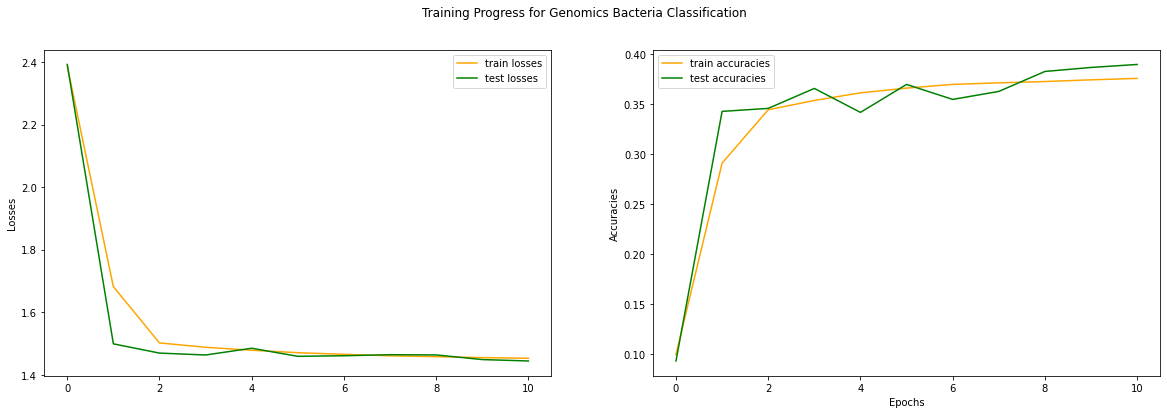

In [16]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

fig.suptitle('Training Progress for Genomics Bacteria Classification')
axs[0].plot(train_losses, color='orange', label='train losses')
axs[0].plot(test_losses, color='green', label='test losses')
axs[0].set(ylabel='Losses')
axs[0].legend()
axs[1].plot(train_accuracies, color='orange', label='train accuracies')
axs[1].plot(test_accuracies, color='green', label='test accuracies')

axs[1].set(xlabel='Epochs', ylabel='Accuracies')
axs[1].legend()